In [1]:
"""
Test Lindblad based method for ground state preparation for TFIM-6 model.
"""

from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d

import numpy as np # generic math functions
import scipy.linalg as la
import matplotlib.pyplot as plt
from qutip import Qobj, mesolve

from lindblad import Lindblad

# Generate Lindbladian

In [2]:
##### define model parameters #####
L=6 # system size
J=1.0 # spin zz interaction
g=1.2 # z magnetic field strength

##### define spin model
# site-coupling lists (PBC for both spin inversion sectors)
h_field=[[-g,i] for i in range(L)]
J_zz=[[-J,i,i+1] for i in range(L-1)] # no PBC
# define spin static and dynamic lists
static =[["zz",J_zz],["x",h_field]] # static part of H
dynamic=[] # time-dependent part of H
# construct spin basis in pos/neg spin inversion sector depending on APBC/PBC
spin_basis = spin_basis_1d(L=L)
# build TFIM-6 Hamiltonians
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
H=hamiltonian(static,dynamic,basis=spin_basis,dtype=np.float64,**no_checks)
# calculate spin energy levels
E_GS,psi_GS = H.eigsh(k=1,which="SA")
psi_GS = psi_GS.flatten()
print('E_GS = ', E_GS)
H_mat = np.array(H.todense())
E_H , psi_H = la.eigh(H_mat)
gap = E_H[1] - E_H[0]
print('gap = ', gap)

E_GS =  [-8.26934435]
gap =  0.8054850431254597


# Generate Lindblad

In [3]:
a = 2.5*la.norm(H_mat,2)
da = 0.5*la.norm(H_mat,2)
b = gap
db = gap
filter_params = {'a': a, 'b': b, 'da': da, 'db': db} 
A = hamiltonian([ ['z',[[1.0,0]]] ],[],basis=spin_basis,dtype=np.float64,**no_checks)
A_mat = np.array(A.todense())
lb = Lindblad(H_mat, A_mat, filter_params)

# Exact Lindblad simulation

In [4]:
# random initial state
np.random.seed(1)
vt = np.random.randn(lb.Ns)
# worst case: make psi0 and psi_GS orthogonal
psi0 = vt.copy()
psi0 -= psi_GS * np.vdot(psi_GS,psi0)
psi0 = psi0 / la.norm(psi0)
print('|<psi0|psiGS>| = ', np.abs(np.vdot(psi_GS,psi0)))

#Exact simulation
T = 200
num_t=200
times= np.arange(num_t+1) * (T/num_t)
H_obj = Qobj(H_mat)
rho_GS_obj = Qobj(np.outer(psi_GS, psi_GS.conj())) #initial state
lb.construct_jump_exact() #construct Jump operator
result = mesolve(H_obj, Qobj(psi0), times, [Qobj(lb.A_jump)],
            [H_obj, rho_GS_obj])
avg_energy_e = result.expect[0] #list of energy
avg_pGS_e = result.expect[1] #list of overlap

|<psi0|psiGS>| =  6.938893903907228e-17


In [5]:
#Discrete Lindblad
# avg_energy_l: list of energy
# avg_pGS_l: list of overlap
# time_H_l: list of H simulation time
# rho_all_l: list of rho_n
S_s = 5.0 / db #Integral truncation
M_s = int(5/db/(2*np.pi/(4*a))) #Integral stepsize
num_segment = 2#discrete segment
num_rep = 100 #average repetition (used to recover \rho_n after tracing out)
times_l, avg_energy_l, avg_pGS_l, time_H_l, rho_all_l = lb.Lindblad_simulation(T, num_t,
        num_segment, psi0, num_rep, S_s, M_s,
        psi_GS, intorder=2)

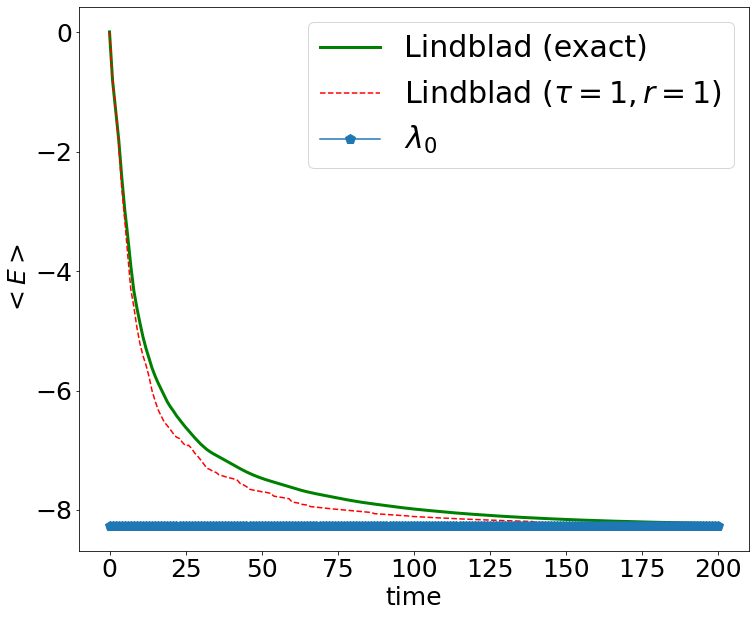

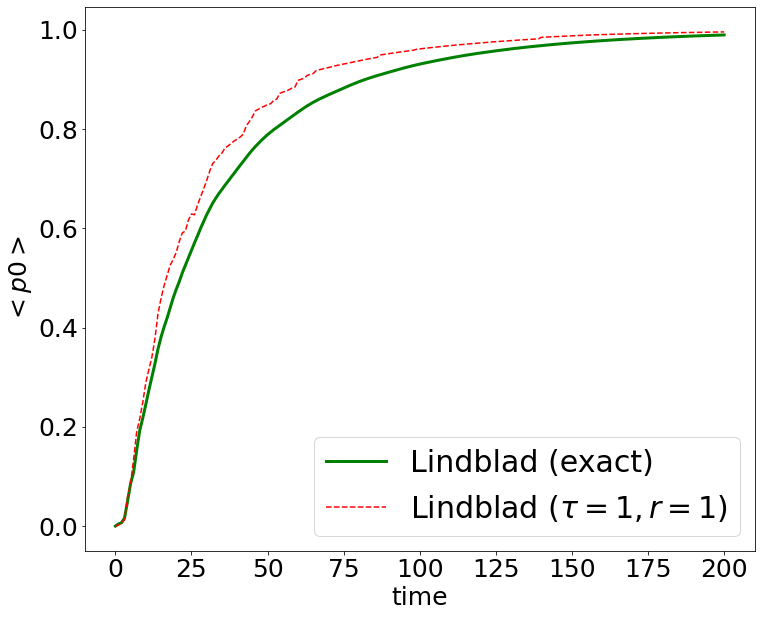

In [6]:
plt.figure(figsize=(12,10))
plt.plot(times, avg_energy_e, 'g-', label='Lindblad (exact)', linewidth=3, markersize=10)
plt.plot(times_l, avg_energy_l, 'r--', label=r'Lindblad $(\tau=1,r=1)$', linewidth=1.5, markersize=10)
plt.plot(times, np.ones_like(times)*E_GS, 'p-', label=r'$\lambda_0$', linewidth=1.5,markersize=10)
plt.legend()
plt.xlabel('time',fontsize=25)
plt.ylabel(r'$<E>$',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)
plt.show()

plt.figure(figsize=(12,10))
plt.plot(times, avg_pGS_e,'g-', label=r'Lindblad (exact)', linewidth=3, markersize=20)
plt.plot(times_l, avg_pGS_l, 'r--', label=r'Lindblad $(\tau=1,r=1)$', linewidth=1.5, markersize=10)
plt.legend()
plt.xlabel('time',fontsize=25)
plt.ylabel(r'$<p0>$',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30,loc="lower right")
plt.show()

In [8]:
#Continuous Lindblad simulation
# avg_energy_s: list of energy
# avg_pGS_s: list of overlap
# time_H_s: list of H simulation time
# rho_all_s: list of rho_n
num_t = 10*num_segment*num_t #small time step
num_segment=1
times_s, avg_energy_s, avg_pGS_s, time_H_s, rho_all_s = lb.Lindblad_simulation(T, num_t,
        num_segment, psi0, num_rep, S_s, M_s,
        psi_GS, intorder=2)

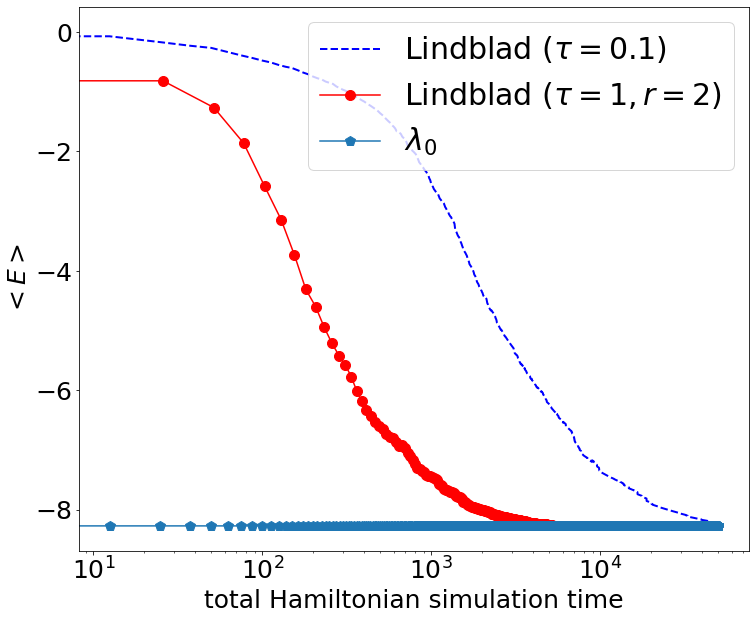

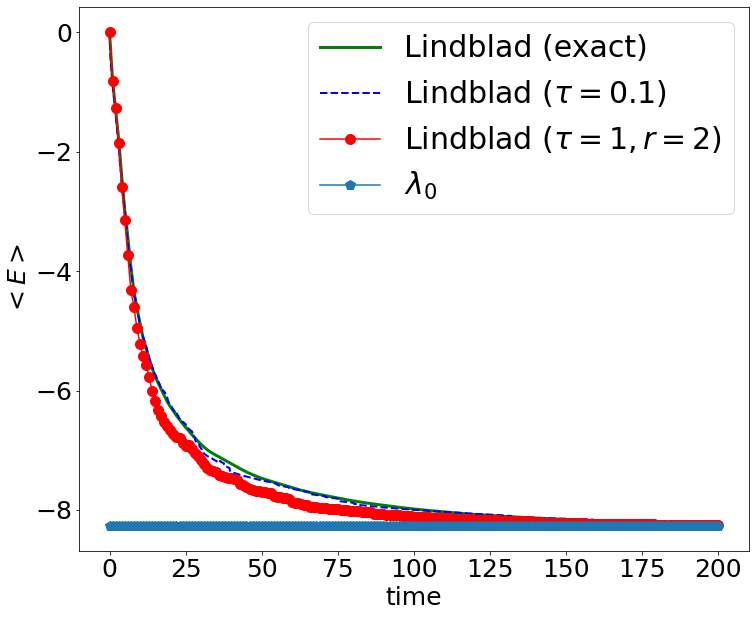

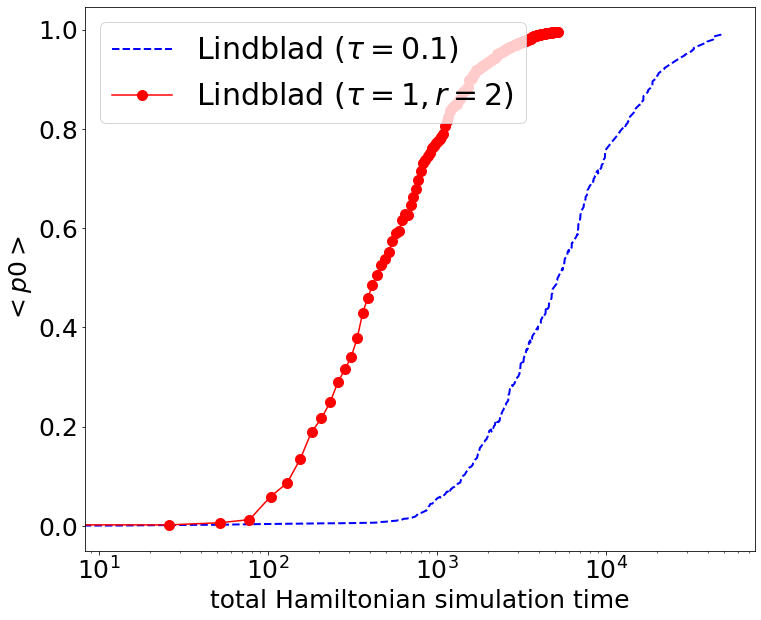

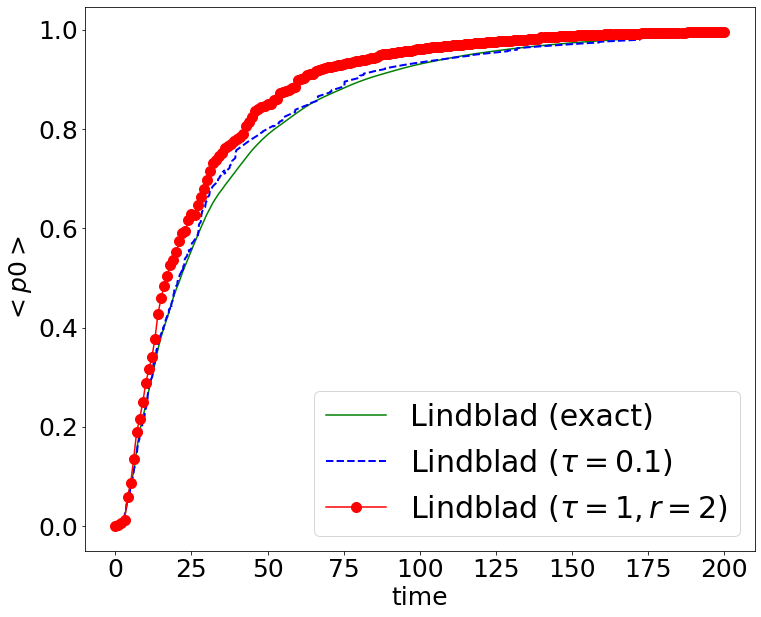

In [9]:
plt.figure(figsize=(12,10))
plt.plot(time_H_s, avg_energy_s,'b--', label=r'Lindblad $(\tau=0.1)$', linewidth=2, markersize=10)
plt.plot(time_H_l, avg_energy_l, 'r-o', label=r'Lindblad $(\tau=1,r=2)$', linewidth=1.5, markersize=10)
plt.plot(time_H_s, np.ones_like(time_H_s)*E_GS, 'p-', label=r'$\lambda_0$', linewidth=1.5,markersize=10)
plt.legend()
plt.xlabel('total Hamiltonian simulation time',fontsize=25)
plt.ylabel(r'$<E>$',fontsize=25)
plt.xscale('log')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)
plt.savefig('TFIM_6_energy_H_time.pdf')
plt.show()

plt.figure(figsize=(12,10))
plt.plot(times, avg_energy_e, 'g-', label='Lindblad (exact)', linewidth=3, markersize=10)
plt.plot(times_s, avg_energy_s,'b--', label=r'Lindblad $(\tau=0.1)$', linewidth=2, markersize=10)
plt.plot(times_l, avg_energy_l, 'r-o', label=r'Lindblad $(\tau=1,r=2)$', linewidth=1.5, markersize=10)
plt.plot(times, np.ones_like(times)*E_GS, 'p-', label=r'$\lambda_0$', linewidth=1.5,markersize=10)
plt.legend()
plt.xlabel('time',fontsize=25)
plt.ylabel(r'$<E>$',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)
plt.savefig('TFIM_6_energy_time.pdf')
plt.show()


plt.figure(figsize=(12,10))
plt.plot(time_H_s, avg_pGS_s,'b--', label=r'Lindblad $(\tau=0.1)$', linewidth=2, markersize=10)
plt.plot(time_H_l, avg_pGS_l, 'r-o', label=r'Lindblad $(\tau=1,r=2)$', linewidth=1.5, markersize=10)
plt.legend()
plt.xlabel('total Hamiltonian simulation time',fontsize=25)
plt.ylabel(r'$<p0>$',fontsize=25)
plt.xscale('log')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30,loc="upper left")
plt.savefig('TFIM_6_overlap_H_time.pdf')
plt.show()

plt.figure(figsize=(12,10))
plt.plot(times, avg_pGS_e, 'g-', label=r'Lindblad (exact)', linewidth=1.5, markersize=10)
plt.plot(times_s, avg_pGS_s,'b--', label=r'Lindblad $(\tau=0.1)$', linewidth=2, markersize=10)
plt.plot(times_l, avg_pGS_l, 'r-o', label=r'Lindblad $(\tau=1,r=2)$', linewidth=1.5, markersize=10)
plt.legend()
plt.xlabel('time',fontsize=25)
plt.ylabel(r'$<p0>$',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=30,loc="lower right")
plt.savefig('TFIM_6_overlap_time.pdf')
plt.show()

# Draw function f and \hat{f}

/var/folders/0k/l2cqwppj67g8y4c4nt5v5q7w0000gn/T/ipykernel_65014/4050673477.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x=np.linspace(-30/db,30/db, num=np.int(100/b))


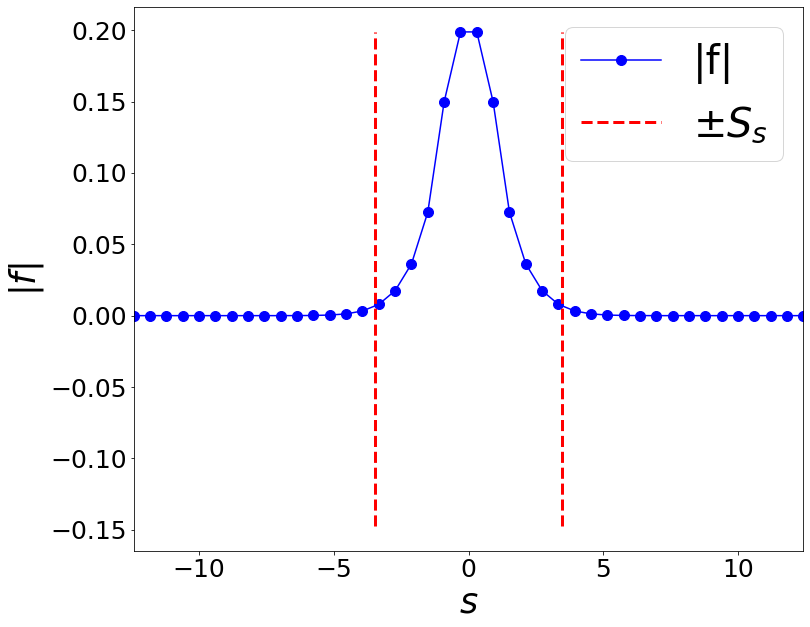

/Users/zhiyan_ding/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/zhiyan_ding/opt/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


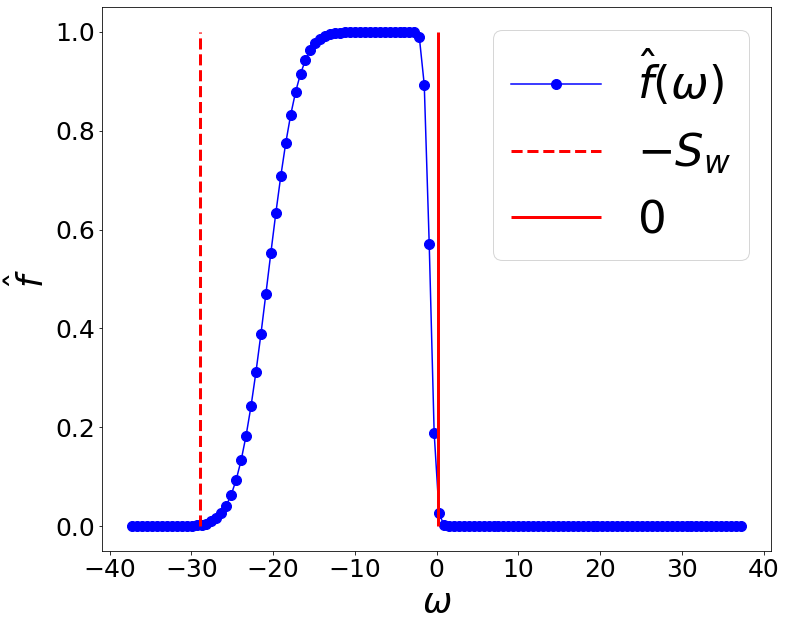

In [7]:
x=np.linspace(-30/db,30/db, num=np.int(100/b))
f=np.zeros(len(x),'complex')
hat_f_prefect=np.zeros(len(x),'complex')
for n in range(len(x)):
    f[n]=lb.filter_time(x[n])
    hat_f_prefect[n]=lb.filter_freq(x[n])
plt.figure(figsize=(12,10))
plt.plot(x,np.abs(f), 'o-', color = "b", label='|f|', linewidth=1.5,markersize=10)
# plt.plot(x,np.imag(f), '*-', color = "g", label='Im(f)', linewidth=1.5,markersize=10)
plt.vlines(-2.8/db,min(np.imag(f)), max(np.abs(f)), colors = "r", linestyles = "dashed", 
           label="$\pm S_s$", linewidth=3)
plt.vlines(2.8/db,min(np.imag(f)), max(np.abs(f)), colors = "r", linestyles = "dashed", linewidth=3)
plt.xlabel('$s$',fontsize=35)
plt.ylabel('$|f|$',fontsize=35)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=40,loc='upper right')
plt.xlim(-10/db, 10/db) 
plt.savefig('function_f.pdf')
plt.show()
plt.figure(figsize=(12,10))
plt.plot(x,hat_f_prefect,'o-', color = "b", label=r'$\hat{f}(\omega)$', linewidth=1.5,markersize=10)
plt.vlines(-a-2*da,0, max(hat_f_prefect), colors = "r", linestyles = "dashed", 
           label="$-S_w$", linewidth=3)
plt.vlines(0.2,0, max(hat_f_prefect), colors = "r", 
           label="$0$", linewidth=3)
plt.xlabel('$\omega$',fontsize=35)
plt.ylabel('$\hat{f}$',fontsize=35)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=45,loc='upper right')
plt.savefig('function_hat_f.pdf')
plt.show()